# Homework 3 Graph Neural Networks (GNN)

Welcome to the Graph Neural Networks (GNN) programming assignment! In this assignment, you will have the opportunity to dive into the exciting world of graph analysis using deep learning techniques. Graphs are ubiquitous in the real world, and GNNs provide a powerful tool to analyze and learn from them. The objective of this assignment is to familiarize you with the basics of GNNs and to give you hands-on experience implementing them using popular deep learning frameworks. By the end of this assignment, you will have a solid understanding of how GNNs work, how they can be used to analyze graphs, and how to implement them in practice. Let's get started!

## Environment
To running this code, you have to prepare a python environment. We recommend python version >= 3.7. You will need to install `torch`, `torch_geometric`, `torch_scatter`, `torch_sparse`, `torchmetrics`, `networkx`, `numpy` and `jupyter` packages. And in order to run the tests locally, you also need to install `matplotlib`.

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torchmetrics

%matplotlib inline
import matplotlib.pyplot as plt

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.6 MB/s eta 0:00:00


Graph Neural Networks (GNNs) have become a popular research field in the deep learning community, with a focus on applying deep learning concepts to irregular structured data found in graphs. The aim is to enable neural networks to reason about objects and their relationships. This is accomplished through a neural message passing scheme where node features are iteratively updated by gathering information from their neighbors. The tutorial will cover fundamental concepts in deep learning on graphs using GNNs and will use the PyTorch Geometric (PyG) library, which is an extension of the PyTorch framework and offers various methods and utilities to simplify GNN implementation.

We will start with the **PPI** dataset. The protein-protein interaction networks from the [Predicting Multicellular Function through Multi-layer Tissue Networks](https://arxiv.org/abs/1707.04638) paper, containing positional gene sets, motif gene sets and immunological signatures as features (50 in total) and gene ontology sets as labels (121 in total).

The task for PPI is Node Classification, and this is a [multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification) task. Multi-label classification is a type of classification task where each instance can be assigned to one or more classes. In contrast, in single-label classification, each instance can be assigned to only one class. In multi-label classification, the number of classes is not fixed and can vary from instance to instance. The PPI dataset is an example of a multi-label classification task where each instance can be assigned to one or more of the 121 classes.

In [ ]:
from torch_geometric.datasets import PPI

# You can choose whether to normalize the node features
train_dataset = PPI(root='data', split='train')
val_dataset = PPI(root='data', split='val')
print(f'Train Dataset: {train_dataset}:')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

Extracting data/ppi.zip
Processing...


Train Dataset: PPI(20):
Number of graphs: 20
Number of features: 50
Number of classes: 121


Done!


We can see that the train set has 20 graphs. Every node have 50 features. We can take a close look at the first graph.

In [ ]:
data = train_dataset[0]  # Get the first graph object.

print(data)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Number of nodes: 1767
Number of edges: 32318
Average node degree: 18.29
Is undirected: True


In PyTorch Geometric, each graph is represented by a `Data` object, which contains all the necessary information to describe the graph. By calling `print(data)`, we can obtain a summary of the object's attributes and shapes. The data object has three attributes: (1)`edge_index`, which provides the graph connectivity information as a tuple of source and destination node indices for each edge, (2) `x`, which represents node features as a matrix (tensor) where each row corresponds to a node and each column represents a feature dimension, (3) `y`, which contains node labels, where each node is assigned to 121 classes. The goal is to infer the community assignment for the remaining nodes. The Data object also offers utility functions that allow us to check basic properties of the graph, such as whether there are isolated nodes, self-loops, or whether the graph is undirected.

In [ ]:
print(data.y[0])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])


Here we can see that for this multi-label classification, one data point can belong to multiple classes.

We can visualize the graph using networkx.

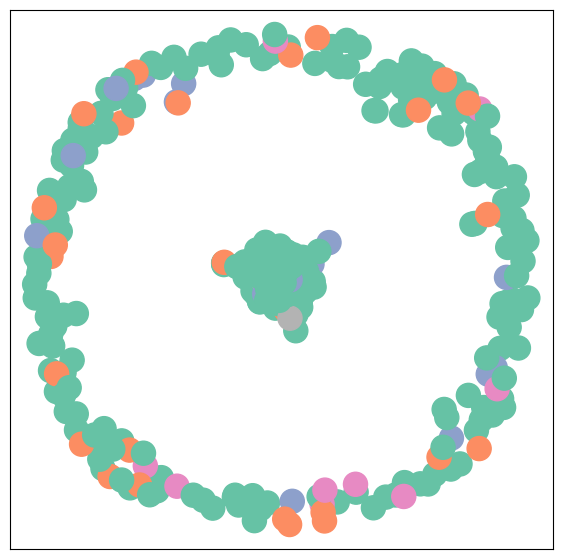

In [ ]:
import networkx as nx

from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=21), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
# We random choose a class if there are more than 1 class for a data point
visualize_graph(G, color=torch.argmax(data.y, dim=1))

In some classification datasets, the graphs are usually small. Thus, it is a good practice to batch these graphs before feeding them into a Graph Neural Network to ensure that the CPU/GPU is fully utilized. In other domains such as image or language, this is typically done by resizing or padding each example to have the same shape, and then grouping examples in an additional dimension with a length equal to the number of examples in a mini-batch, referred to as the batch_size. However, these approaches are not feasible or may lead to unnecessary memory consumption in GNNs. PyTorch Geometric takes a different approach to achieve parallelization across multiple examples. Here, adjacency matrices are stacked diagonally, creating a single graph that contains multiple isolated subgraphs. Node and target features are then concatenated in the node dimension.

The procedure mentioned above offers several crucial benefits over other batching procedures:

GNN operators that use message passing do not require any modifications since messages are not exchanged between nodes belonging to different graphs.
There is no computational or memory overhead as adjacency matrices are stored sparsely, containing only non-zero entries, i.e., the edges.

PyTorch Geometric automatically performs the task of batching multiple graphs into a single large graph using the `torch_geometric.data.DataLoader` class.

In [ ]:
from torch_geometric.loader import DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 8
DataBatch(x=[20502, 50], edge_index=[2, 598262], y=[20502, 121], batch=[20502], ptr=[9])

Step 2:
Number of graphs in the current batch: 8
DataBatch(x=[16153, 50], edge_index=[2, 424728], y=[16153, 121], batch=[16153], ptr=[9])

Step 3:
Number of graphs in the current batch: 4
DataBatch(x=[8251, 50], edge_index=[2, 203378], y=[8251, 121], batch=[8251], ptr=[5])



In principle, we can determine the category of a protein only based on its features representation without considering any relational information. We can confirm this by building a basic MLP that works only on input node features, using shared weights across all nodes.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(train_dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
model = MLP(hidden_channels=16).to(device)
print(model)
# loss_fn = torch.nn.CrossEntropyLoss()  # Define loss loss_fn.
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      for data in train_loader:
            out = model(data.x.to(device))  # Perform a single forward pass.
            loss = loss_fn(out, data.y.to(device))  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.

MLP(
  (lin1): Linear(in_features=50, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=121, bias=True)
)


## Task 1: Compute the ROC AUC score [2 pts]
To evaluate the performance of our model on the PPI dataset, we will use the [ROC AUC score](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). 

ROC (Receiver Operating Characteristic) AUC (Area Under the Curve) is a performance metric for binary classification problems that measures the area under the ROC curve. The ROC curve is a plot of True Positive Rate (TPR) against False Positive Rate (FPR) at different classification thresholds. A perfect classifier has a ROC AUC score of 1, while a random classifier has a ROC AUC score of 0.5.

In the case of multi-label classification tasks like PPI, there are two types of averaging methods that can be used to compute the ROC AUC score:

1. **Macro-average ROC AUC**: computes the ROC AUC score for each class separately and then takes the average of the scores. It treats all classes equally regardless of their frequency in the dataset.

2. **Micro-average ROC AUC**: computes the ROC AUC score globally by counting the total true positives, false positives, and true negatives across all classes.

In our case, since the PPI dataset is imbalanced, we will use the macro-average ROC AUC score to evaluate the performance of our model.

You need to complete the `mlp_test` function to compute the ROC AUC score. You can use `MultilabelAUROC` from `torchmetrics` to compute the score.

In [ ]:
#export
from torchmetrics.classification import MultilabelAUROC
import torch
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

def mlp_test(model, loss_fn, loader, device):
      """
      model: pytorch GNN model
      loss_fn: loss function
      loader: DataLoader
      device: device eused to bind the model and tensor
      """
      model.eval()
      total_loss = 0.0
      auroc_score = 0.0
      total_nodes_n = 0
      # TODO: calculate the auroc_score using marco average
      auroc = MultilabelAUROC(num_labels=121)
      
      with torch.no_grad():
            for data in loader:
                  data.x, data.y = data.x.to(device), data.y.to(device)
                  out = model(data.x)
                  loss = loss_fn(out, data.y)
                  total_loss += loss * data.x.shape[0]
                  total_nodes_n += data.x.shape[0]
                  auroc.update(out, data.y.to(torch.long))
            
      auroc_score = auroc.compute().mean().item()            
      return total_loss / total_nodes_n, auroc_score

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# You can tune the hyperparameters like epoch_num, learning_rate, ...
epoch_num = 50
for epoch in range(1, epoch_num):
    train()
    train_loss, train_auroc = mlp_test(model, loss_fn, train_loader, device)
    val_loss, val_auroc = mlp_test(model, loss_fn, val_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train auroc: {train_auroc:.4f}, Valid Loss: {val_loss:.4f}, Valid Auroc: {val_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.5423, Train auroc: 0.5855, Valid Loss: 0.5350, Valid Auroc: 0.5790
Epoch: 002, Train Loss: 0.5422, Train auroc: 0.5854, Valid Loss: 0.5350, Valid Auroc: 0.5787
Epoch: 003, Train Loss: 0.5422, Train auroc: 0.5853, Valid Loss: 0.5348, Valid Auroc: 0.5783
Epoch: 004, Train Loss: 0.5421, Train auroc: 0.5849, Valid Loss: 0.5346, Valid Auroc: 0.5779
Epoch: 005, Train Loss: 0.5422, Train auroc: 0.5847, Valid Loss: 0.5350, Valid Auroc: 0.5777
Epoch: 006, Train Loss: 0.5423, Train auroc: 0.5844, Valid Loss: 0.5352, Valid Auroc: 0.5778
Epoch: 007, Train Loss: 0.5423, Train auroc: 0.5848, Valid Loss: 0.5349, Valid Auroc: 0.5783
Epoch: 008, Train Loss: 0.5422, Train auroc: 0.5852, Valid Loss: 0.5347, Valid Auroc: 0.5786
Epoch: 009, Train Loss: 0.5421, Train auroc: 0.5851, Valid Loss: 0.5347, Valid Auroc: 0.5784
Epoch: 010, Train Loss: 0.5421, Train auroc: 0.5853, Valid Loss: 0.5348, Valid Auroc: 0.5786
Epoch: 011, Train Loss: 0.5421, Train auroc: 0.5852, Valid Loss: 0.534

Although we also let the loss drop here, we did not use the structural relationship of the graph. Obviously we lost a lot of information. If we can make good use of these meaningful information, then our loss can be further reduced.

To convert the MLP to a GNN, we can swap the torch.nn.Linear layers with PyG's GNN operators. We can replace the linear layers with the GCNConv module.

The GCN layer (Kipf et al. (2017)) is defined as:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

 
Here, $\mathbf{W}^{(\ell + 1)}$ is a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge. On the other hand, a single Linear layer is defined as:


$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

It does not use neighboring node information.

We can perform this replacement because GNN operators are designed to take into account the topology of the graph. By replacing the Linear layers with GNN operators, we can use information from neighboring nodes to make predictions.

## Task 2: Node Classfication Model Design [5 pts]

You need to complete the following `NodeGCN` class. We recommend that you use the `GCNConv` to finish the task.

To investigate the impact of GNN layers on model performance, you may want to experiment with different types of layers. For instance, you can try substituting all GCNConv layers with GATConv layers that employ attention mechanisms.

In [ ]:
#export
from torch_geometric.nn import GCNConv

### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###
class NodeGCN(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = GCNConv(50, 16)
      self.conv2 = GCNConv(16, 32)
      self.conv3 = GCNConv(32, 64)
      self.conv4 = GCNConv(64, 128)
      self.conv5 = GCNConv(128, 256)
      self.conv6 = GCNConv(256, 512)
      self.conv7 = GCNConv(512, 121)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv5(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv6(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv7(x, edge_index)

        return x

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [ ]:
model = NodeGCN().to(device)
print(model)
# loss_fn = torch.nn.CrossEntropyLoss()  # Define loss loss_fn.
loss_fn = torch.nn.BCEWithLogitsLoss()
# You can tune the hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-5)  # Define optimizer.

NodeGCN(
  (conv1): GCNConv(50, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (conv4): GCNConv(64, 128)
  (conv5): GCNConv(128, 256)
  (conv6): GCNConv(256, 512)
  (conv7): GCNConv(512, 121)
)


In [ ]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      total_loss = 0.0
      for data in train_loader:
            out = model(data.x.to(device), data.edge_index.to(device))  # Perform a single forward pass.
            loss = loss_fn(out, data.y.to(device))  # Compute the loss solely based on the training nodes.
            total_loss += loss
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.

## Task 3: Finish the `gnn_test` function and compute the ROC AUC score [2 pts]

In [ ]:
#export
from torchmetrics.classification import MultilabelAUROC
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

def gnn_test(model, loss_fn, loader, device):
      """
      model: pytorch GNN model
      loss_fn: loss function
      loader: DataLoader
      device: device eused to bind the model and tensor
      """
      model.eval()
      total_loss = 0.0
      auroc_score = 0.0
      total_nodes_n = 0
      # TODO: Finish this function, calculate the auroc score using macro average
      auroc = MultilabelAUROC(num_labels=121)

      with torch.no_grad():
            for data in loader:
                  data.x, data.y = data.x.to(device), data.y.to(device)
                  out = model(data.x, data.edge_index.to(device))
                  loss = loss_fn(out, data.y.to(device))  # Compute the loss solely based on the training nodes.
                  total_loss += loss * data.x.shape[0]
                  total_nodes_n += data.x.shape[0]
                  auroc.update(out, data.y.to(torch.long))
      auroc_score = auroc.compute().mean().item()            
      return total_loss / total_nodes_n, auroc_score

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-7)

epoch_num = 2000
for epoch in range(1, epoch_num):
    train()
    train_loss, train_auroc = gnn_test(model, loss_fn, train_loader, device)
    val_loss, val_auroc = gnn_test(model, loss_fn, val_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train auroc: {train_auroc:.4f}, Valid Loss: {val_loss:.4f}, Valid Auroc: {val_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6033, Train auroc: 0.4326, Valid Loss: 0.5951, Valid Auroc: 0.4343
Epoch: 002, Train Loss: 0.6137, Train auroc: 0.4542, Valid Loss: 0.6125, Valid Auroc: 0.4548
Epoch: 003, Train Loss: 0.6151, Train auroc: 0.4393, Valid Loss: 0.6073, Valid Auroc: 0.4402
Epoch: 004, Train Loss: 0.5864, Train auroc: 0.4394, Valid Loss: 0.5816, Valid Auroc: 0.4397
Epoch: 005, Train Loss: 0.6002, Train auroc: 0.4367, Valid Loss: 0.5969, Valid Auroc: 0.4372
Epoch: 006, Train Loss: 0.5910, Train auroc: 0.4365, Valid Loss: 0.5862, Valid Auroc: 0.4370
Epoch: 007, Train Loss: 0.5911, Train auroc: 0.4393, Valid Loss: 0.5825, Valid Auroc: 0.4398
Epoch: 008, Train Loss: 0.5838, Train auroc: 0.4398, Valid Loss: 0.5769, Valid Auroc: 0.4400
Epoch: 009, Train Loss: 0.5840, Train auroc: 0.4471, Valid Loss: 0.5797, Valid Auroc: 0.4472
Epoch: 010, Train Loss: 0.5842, Train auroc: 0.4532, Valid Loss: 0.5802, Valid Auroc: 0.4533
Epoch: 011, Train Loss: 0.5792, Train auroc: 0.4474, Valid Loss: 0.574

### Save the model
Save the NodeGCN model to file.

In [ ]:
torch.save(model.state_dict(), "node_gcn.pth")
print("Saved PyTorch Model State to node_gcn.pth")

Saved PyTorch Model State to node_gcn.pth


In [ ]:
model = NodeGCN().to(device)
model.load_state_dict(torch.load("node_gcn.pth"))
val_loss, val_auroc = gnn_test(model, loss_fn, val_loader, device)
print("val_loss: %f, val_auroc: %f" % (val_loss, val_auroc))

val_loss: 0.458481, val_auroc: 0.768188


## Graph Classification

The upcoming section will focus on the application of Graph Neural Networks (GNNs) to graph classification, which involves classifying complete graphs (rather than individual nodes) based on structural graph characteristics using a dataset of graphs. In this scenario, the objective is to embed complete graphs in a manner that makes them linearly separable for a given task.

Graph classification is often used for predicting molecular properties. In this context, molecules are represented as graphs, and the goal may be to determine if a molecule inhibits the HIV virus or not.

One source of graph classification datasets is the `TUDatasets` collection, curated by TU Dortmund University. These datasets are available through the torch_geometric.datasets.TUDataset module in PyTorch Geometric. For the purpose of this tutorial, we will load a subset of the TUDatasets: the protein graphs.

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='PROTEINS_full')

print()
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/PROTEINS_full/PROTEINS_full.zip
Processing...



Dataset: PROTEINS_full(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Is undirected: True


Done!


This dataset provides about one thousand graphs. This is a binary classfication task.

In [ ]:
### DO NOT CHANGE THE CODE IN THIS CELL ###

# We split the dataset into train set, valid set and test set
torch.manual_seed(12345678)
dataset = dataset.shuffle()
test_ratio = 0.15
test_len = int(len(dataset) * test_ratio)
train_valid_len = len(dataset) - test_len
train_ratio = 0.7
train_len = int(len(dataset) * train_ratio)
valid_len = len(dataset) - train_len - test_len
train_dataset = dataset[:train_len]
valid_dataset = dataset[train_len:train_len + valid_len]
test_dataset = dataset[train_len + valid_len:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of valid graphs: {len(valid_dataset)}')

Number of training graphs: 779
Number of valid graphs: 168


In [ ]:
from torch_geometric.loader import DataLoader
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9522], x=[2532, 3], y=[64], batch=[2532], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 7766], x=[2084, 3], y=[64], batch=[2084], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9156], x=[2506, 3], y=[64], batch=[2506], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9588], x=[2548, 3], y=[64], batch=[2548], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 11064], x=[3050, 3], y=[64], batch=[3050], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 8890], x=[2383, 3], y=[64], batch=[2383], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9172], x=[2368, 3], y=[64], batch=[2368], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9748], x=[2452, 3], y=[64], 

To train a GNN for graph classification, we typically follow a three-step recipe:

- Embedding each node by performing multiple rounds of message passing.
- Aggregating the node embeddings into a single graph embedding, which is also known as the readout layer.
- Training a classifier on the graph embedding.

There are several readout layer options available, but the most common one is to take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

This functionality is provided by PyTorch Geometric via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool). Given the node embeddings of all nodes in the mini-batch and the `batch` assignment vector, this function computes a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.


## Task 4: Graph Classfication using GCNConv [5 pts]

Please design a GNN model based on GCNConv to do this graph classification job. Complete the following class.

In [ ]:
#export
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###


class GraphGCN(torch.nn.Module):
    def __init__(self):
        super(GraphGCN, self).__init__()
        # TODO: Please design your MLP layers
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 128)
        self.conv5 = GCNConv(128, 256)
        self.conv6 = GCNConv(256, 512)
        self.conv7 = GCNConv(512, 1024)
        self.fc = Linear(1024, 2)
        pass

    def forward(self, x, edge_index, batch):
        # TODO: Finish this function
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.relu(self.conv7(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [ ]:
model = GraphGCN().to(device)
print(model)

GraphGCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (conv4): GCNConv(64, 128)
  (conv5): GCNConv(128, 256)
  (conv6): GCNConv(256, 512)
  (conv7): GCNConv(512, 1024)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


## Task 5: Finish the `graph_test` function and compute the ROC AUC score [2 pts]

In [ ]:
#export
from torchmetrics.classification import MulticlassAUROC
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

def graph_test(model, loss_fn, loader, device):
     """
     model: pytorch GNN model
     loss_fn: loss function
     loader: DataLoader
     device: device eused to bind the model and tensor
     """
     model.eval()
     auroc_score = 0.0
     # TODO: Finish this function to calculate AUROC score
     auroc = MulticlassAUROC(num_classes=2)
     with torch.no_grad():
       for data in loader:
         data.x, data.y = data.x.to(device), data.y.to(device)
         out = model(data.x, data.edge_index.to(device), data.batch.to(device))
         auroc.update(out, data.y.to(torch.long))

     auroc_score = auroc.compute().mean().item()
     return auroc_score

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

learning_rate = 1e-3
epoch_num = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device))  # Perform a single forward pass.
        loss = loss_fn(out, data.y.to(device))  # Compute the loss.
        total_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return total_loss / len(train_loader)

for epoch in range(epoch_num):
    train_loss = train()
    train_auroc = graph_test(model, loss_fn, train_loader, device)
    valid_auroc = graph_test(model, loss_fn, valid_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Train Auc: {train_auroc:.4f}, Valid Auc: {valid_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Train Loss: 0.67906, Train Auc: 0.6703, Valid Auc: 0.7168
Epoch: 001, Train Loss: 0.67859, Train Auc: 0.6354, Valid Auc: 0.6745
Epoch: 002, Train Loss: 0.66859, Train Auc: 0.6828, Valid Auc: 0.7404
Epoch: 003, Train Loss: 0.64000, Train Auc: 0.6944, Valid Auc: 0.7423
Epoch: 004, Train Loss: 0.64209, Train Auc: 0.7015, Valid Auc: 0.7296
Epoch: 005, Train Loss: 0.62255, Train Auc: 0.6996, Valid Auc: 0.7341
Epoch: 006, Train Loss: 0.62197, Train Auc: 0.6909, Valid Auc: 0.7139
Epoch: 007, Train Loss: 0.60804, Train Auc: 0.6638, Valid Auc: 0.7243
Epoch: 008, Train Loss: 0.61907, Train Auc: 0.6918, Valid Auc: 0.6940
Epoch: 009, Train Loss: 0.61961, Train Auc: 0.6982, Valid Auc: 0.7037
Epoch: 010, Train Loss: 0.61544, Train Auc: 0.7030, Valid Auc: 0.7120
Epoch: 011, Train Loss: 0.60907, Train Auc: 0.7191, Valid Auc: 0.7314
Epoch: 012, Train Loss: 0.60215, Train Auc: 0.6832, Valid Auc: 0.6846
Epoch: 013, Train Loss: 0.61803, Train Auc: 0.7245, Valid Auc: 0.7386
Epoch: 014, Train Lo

In [ ]:
torch.save(model.state_dict(), "graph_gcn.pth")
print("Saved PyTorch Model State to graph_gcn.pth")

Saved PyTorch Model State to graph_gcn.pth


In [ ]:
model = GraphGCN().to(device)
model.load_state_dict(torch.load("graph_gcn.pth"))
graph_test(model, loss_fn, valid_loader, device)

0.7529920339584351

Utilizing neighborhood normalization reduces the capability of GNNs to differentiate certain graph structures.
 
As an alternative, [Morris et al. (2018)](https://arxiv.org/abs/1810.02244) proposes a formulation that completely eliminates neighborhood normalization and adds a simple skip-connection to the GNN layer to retain central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is available as [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

You can use PyG's `GraphConv` instead of `GCNConv`.

# Task 6: Graph Classification using GraphConv [4 pts]

Please design a GNN model based on GraphConv. Complete the following class

In [ ]:
#export
from torch_geometric.nn import GraphConv
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###


class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        # TODO: Finish the design of this GNN model
        self.conv1 = GraphConv(3, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 64)
        self.conv4 = GraphConv(64, 128)
        self.conv5 = GraphConv(128, 256)
        self.conv6 = GraphConv(256, 512)
        self.conv7 = GraphConv(512, 1024)
        self.fc = torch.nn.Linear(1024, 2)

    def forward(self, x, edge_index, batch):
        # TODO: Finish this function
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv5(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv6(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv7(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [ ]:
model = GNN().to(device)
print(model)

GNN(
  (conv1): GraphConv(3, 16)
  (conv2): GraphConv(16, 32)
  (conv3): GraphConv(32, 64)
  (conv4): GraphConv(64, 128)
  (conv5): GraphConv(128, 256)
  (conv6): GraphConv(256, 512)
  (conv7): GraphConv(512, 1024)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epoch_num = 150
learning_rate = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(epoch_num):
    train_loss = train()
    train_auroc = graph_test(model, loss_fn, train_loader, device)
    valid_auroc = graph_test(model, loss_fn, valid_loader, device)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.5f}, Train Auc: {train_auroc:.4f}, Valid Auc: {valid_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Train loss: 0.82014, Train Auc: 0.6716, Valid Auc: 0.6239
Epoch: 001, Train loss: 0.68709, Train Auc: 0.7082, Valid Auc: 0.6809
Epoch: 002, Train loss: 0.68435, Train Auc: 0.7059, Valid Auc: 0.6756
Epoch: 003, Train loss: 0.65440, Train Auc: 0.6984, Valid Auc: 0.6435
Epoch: 004, Train loss: 0.63366, Train Auc: 0.7189, Valid Auc: 0.6813
Epoch: 005, Train loss: 0.64073, Train Auc: 0.7062, Valid Auc: 0.6655
Epoch: 006, Train loss: 0.63618, Train Auc: 0.7214, Valid Auc: 0.6890
Epoch: 007, Train loss: 0.62251, Train Auc: 0.7382, Valid Auc: 0.6891
Epoch: 008, Train loss: 0.59515, Train Auc: 0.7415, Valid Auc: 0.6803
Epoch: 009, Train loss: 0.57841, Train Auc: 0.7395, Valid Auc: 0.6975
Epoch: 010, Train loss: 0.58263, Train Auc: 0.7448, Valid Auc: 0.6888
Epoch: 011, Train loss: 0.59315, Train Auc: 0.7479, Valid Auc: 0.7001
Epoch: 012, Train loss: 0.57362, Train Auc: 0.7472, Valid Auc: 0.7028
Epoch: 013, Train loss: 0.60935, Train Auc: 0.7389, Valid Auc: 0.6862
Epoch: 014, Train lo

In [ ]:
torch.save(model.state_dict(), "graph_gnn.pth")
print("Saved PyTorch Model State to graph_gnn.pth")

Saved PyTorch Model State to graph_gnn.pth


In [ ]:
model = GNN().to(device)
model.load_state_dict(torch.load("graph_gnn.pth"))
graph_test(model, loss_fn, valid_loader, device)

0.7554433941841125

## Submission

When you have tested your code locally, you can upload your notebook with the saved model files to gradescope to get evaluated.

Please submit a zip file to Gradescope that includes the following:

1. The `hw3_gnn.ipynb` notebook file.
2. The `node_gcn.pth` Node GCN saved model file.
3. The `graph_gcn.pth` Graph GCN saved model file.
4. The `graph_gnn.pth` Graph GNN saved model file.
5. The `weights.txt` file required in Q2.3.
6. The `hw3_seq.ipynb` notebook file.
7. The `hw3_VAE.ipynb` notebook file.

These saved models should have the same structure as the class of model in your notebook.

Please make sure that your code runs correctly and that you have included all necessary files in the zip file.
Please test your code before submitting to ensure that it runs correctly and all the outputs match the expected results.

**IMPORTANT**: Please **do not** include a root directory in the zip file. The required files should be compressed directly.